In [1]:
import re
import string
import time
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import unicodedata
import torch
import torch.nn.functional as F
from pathlib import Path
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from nltk.tokenize import word_tokenize
from functools import partial
from multiprocessing import Pool, cpu_count
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk

True

In [2]:
# Set options to display all rows and columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap lines
pd.set_option('display.max_colwidth', None) # Show full content in each cell (esp. for long strings)
census_all = pd.read_csv("census_real_estate_data - all places.csv")
census_county = pd.read_csv("census_real_estate_data_county.csv")
real_df = pd.read_csv("Connecticut_Louisiana_Real_Estate.csv")
social_media_real_estate = pd.read_csv("reddit_real_estate_data_balanced.csv")
crime_data = pd.read_excel("Crime Data(Louisiana_Connecticut).xlsx")
census_all.rename(columns={'state': 'state_fips'}, inplace=True)
census_county.rename(columns={'state': 'state_fips'}, inplace=True)
### Cleaning up the Data
data_list = [census_all, census_county, real_df, social_media_real_estate, crime_data]
for data in data_list:
    # Display initial information
    print(f"Original data shape: {data.shape}")
    print("\nColumns in the dataset:")
    for col in data.columns:
        print(f"- {col}")

    print("\nFirst few rows:")
    print(data.head())

    # Check for missing values
    print("\nMissing values percentage:")
    missing_percentage = data.isnull().mean() * 100

    # Sort missing percentages from highest to lowest
    sorted_missing = missing_percentage.sort_values(ascending=False)
for col, pct in sorted_missing.items():
    if pct > 0:  # Only show columns with missing values
        print(f"{col}: {pct:.2f}%")
census_all.shape
print(census_all.info())
print(census_all.isnull().sum())
print(census_all.isnull().mean() * 100)
data_list = [census_all, census_county, real_df, social_media_real_estate, crime_data]

for data in data_list:
    print(data.shape)
    print(data.info())
    print(data.isnull().sum())
    print(data.isnull().mean() * 100)
# List of datasets
data_list = [census_all, census_county, real_df, social_media_real_estate, crime_data]
dataset_names = ["census_all", "census_county", "real_df", "social_media_real_estate", "crime_data"]

# Threshold for missing values
threshold = 0.8

# Function to clean a dataset
def clean_dataset(data, name):
    print(f"Cleaning dataset: {name}")

    # Step 1: Remove columns with more than 80% missing values
    missing_percentage = data.isnull().mean()
    columns_to_drop = missing_percentage[missing_percentage > threshold].index
    print(f"Columns to drop (more than {threshold * 100}% missing values): {list(columns_to_drop)}")
    data.drop(columns=columns_to_drop, inplace=True)

    # Step 2: Handle remaining missing values (fill with median for numeric columns)
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            if data[col].dtype in ['float64', 'int64']:
                data[col].fillna(data[col].median(), inplace=True)
            else:
                data[col].fillna(data[col].mode()[0], inplace=True)

    # Step 3: Remove duplicate rows
    initial_shape = data.shape
    data.drop_duplicates(inplace=True)
    print(f"Removed {initial_shape[0] - data.shape[0]} duplicate rows.")

    # Step 4: Standardize column names
    data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace('\n', '_')
    print(f"Standardized column names: {list(data.columns)}")

    # Step 5: Display final shape
    print(f"Final shape of {name}: {data.shape}\n")
    return data

# Clean each dataset
for i, data in enumerate(data_list):
    data_list[i] = clean_dataset(data, dataset_names[i])
for data in data_list:
    print(data.isnull().sum())

Original data shape: (5898, 44)

Columns in the dataset:
- NAME
- B01003_001E
- B01002_001E
- B25010_001E
- B15003_017E
- B15003_022E
- B02001_002E
- B02001_003E
- B03003_003E
- B01001_002E
- B01001_026E
- B01001_003E
- B01001_007E
- B01001_012E
- B01001_020E
- B25001_001E
- B25002_002E
- B25002_003E
- B25003_002E
- B25003_003E
- B25077_001E
- B25064_001E
- B25024_002E
- B25024_003E
- B25024_004E
- B25034_001E
- B25081_002E
- B25081_003E
- B25004_001E
- B25003_001E
- B19013_001E
- B19301_001E
- B23025_005E
- B23025_002E
- B17001_002E
- B17001_001E
- C24010_001E
- B19057_002E
- B08303_001E
- B08101_001E
- state_fips
- place
- State
- Year

First few rows:
                                    NAME  B01003_001E  B01002_001E  \
0           Broad Brook CDP, Connecticut         4504         32.1   
1          New Britain city, Connecticut        72988         33.9   
2      Heritage Village CDP, Connecticut         3934         71.6   
3  North Grosvenor Dale CDP, Connecticut         1707    

C:\Users\Admin\AppData\Local\Temp\ipykernel_13200\2007926673.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13200\2007926673.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

Removed 0 duplicate rows.
Standardized column names: ['name', 'b01003_001e', 'b01002_001e', 'b25010_001e', 'b15003_017e', 'b15003_022e', 'b02001_002e', 'b02001_003e', 'b03003_003e', 'b01001_002e', 'b01001_026e', 'b01001_003e', 'b01001_007e', 'b01001_012e', 'b01001_020e', 'b25001_001e', 'b25002_002e', 'b25002_003e', 'b25003_002e', 'b25003_003e', 'b25077_001e', 'b25064_001e', 'b25024_002e', 'b25024_003e', 'b25024_004e', 'b25034_001e', 'b25081_002e', 'b25081_003e', 'b25004_001e', 'b25003_001e', 'b19013_001e', 'b19301_001e', 'b23025_005e', 'b23025_002e', 'b17001_002e', 'b17001_001e', 'c24010_001e', 'b19057_002e', 'b08303_001e', 'b08101_001e', 'state_fips', 'place', 'state', 'year']
Final shape of census_all: (5898, 44)

Cleaning dataset: census_county
Columns to drop (more than 80.0% missing values): []
Removed 0 duplicate rows.
Standardized column names: ['name', 'b01003_001e', 'b01002_001e', 'b25010_001e', 'b15003_017e', 'b15003_022e', 'b02001_002e', 'b02001_003e', 'b03003_003e', 'b01001

C:\Users\Admin\AppData\Local\Temp\ipykernel_13200\2007926673.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13200\2007926673.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

Removed 0 duplicate rows.
Standardized column names: ['unnamed:_0', 'period_begin', 'period_end', 'period_duration', 'region_type', 'region_type_id', 'table_id', 'is_seasonally_adjusted', 'region', 'city', 'state', 'state_code', 'property_type', 'property_type_id', 'median_sale_price', 'median_sale_price_mom', 'median_sale_price_yoy', 'median_list_price', 'median_list_price_mom', 'median_list_price_yoy', 'median_ppsf', 'median_ppsf_mom', 'median_ppsf_yoy', 'median_list_ppsf', 'median_list_ppsf_mom', 'median_list_ppsf_yoy', 'homes_sold', 'homes_sold_mom', 'homes_sold_yoy', 'pending_sales', 'pending_sales_mom', 'pending_sales_yoy', 'new_listings', 'new_listings_mom', 'new_listings_yoy', 'inventory', 'inventory_mom', 'inventory_yoy', 'months_of_supply', 'months_of_supply_mom', 'months_of_supply_yoy', 'median_dom', 'median_dom_mom', 'median_dom_yoy', 'avg_sale_to_list', 'avg_sale_to_list_mom', 'avg_sale_to_list_yoy', 'sold_above_list', 'sold_above_list_mom', 'sold_above_list_yoy', 'price_d

C:\Users\Admin\AppData\Local\Temp\ipykernel_13200\2007926673.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13200\2007926673.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

unnamed:_0                        0
period_begin                      0
period_end                        0
period_duration                   0
region_type                       0
region_type_id                    0
table_id                          0
is_seasonally_adjusted            0
region                            0
city                              0
state                             0
state_code                        0
property_type                     0
property_type_id                  0
median_sale_price                 0
median_sale_price_mom             0
median_sale_price_yoy             0
median_list_price                 0
median_list_price_mom             0
median_list_price_yoy             0
median_ppsf                       0
median_ppsf_mom                   0
median_ppsf_yoy                   0
median_list_ppsf                  0
median_list_ppsf_mom              0
median_list_ppsf_yoy              0
homes_sold                        0
homes_sold_mom              

In [ ]:
social_media_real_estate.head()

,unnamed:_0,title,content,score,url,created_utc,city,state,year,upvote_ratio,date_posted,comments_count,awards_count,comments,content_sentiment_label,content_negative_score,content_neutral_score,content_positive_score,comments_sentiment_label,comments_negative_score,comments_neutral_score,comments_positive_score
0,0,Need help removing my phone number from an unknown property database,"many year ago unknown scammer begin add phone number market real estate listing fl . still get text call investment company ask want sell nonexistent property . first start contact ml tell remove number database , , callstexts still continue day . database sit 'm aware ? way find investment company find number ? one property constantly contact - owner , william erickson , own property people contact property . always address william , appear somewhere secret database access , number connect guy . help would appreciate .",1,https://www.reddit.com/r/RealEstate/comments/1jrb526/need_help_removing_my_phone_number_from_an/,1.743771e+09,Ansonia,Connecticut,2019,1.0,2025-04-04 13:52:54,2,0,"'m sorry . may mr. erickson use phone number . call database might help long run , short run 's workaround . change voicemail message `` hi , [ name ] . call property own william erickson , property know reach owner . others please leave message . '' n't answer call unknown caller . text , simply answer stop . use kind automate system , take list . human also respect . 's ton place info could . assume n't want get new number , would suggest get call screen app like hiya 've find quite effective block junk call .",Negative,0.611182,0.370701,0.018117,Neutral,0.372709,0.587213,0.040078
1,1,Need help removing my phone number from an unknown property database,"many year ago unknown scammer begin add phone number market real estate listing fl . still get text call investment company ask want sell nonexistent property . first start contact ml tell remove number database , , callstexts still continue day . database sit 'm aware ? way find investment company find number ? one property constantly contact - owner , william erickson , own property people contact property . always address william , appear somewhere secret database access , number connect guy . help would appreciate .",1,https://www.reddit.com/r/RealEstate/comments/1jrb526/need_help_removing_my_phone_number_from_an/,1.743771e+09,Ansonia,Connecticut,2020,1.0,2025-04-04 13:52:54,2,0,"'m sorry . may mr. erickson use phone number . call database might help long run , short run 's workaround . change voicemail message `` hi , [ name ] . call property own william erickson , property know reach owner . others please leave message . '' n't answer call unknown caller . text , simply answer stop . use kind automate system , take list . human also respect . 's ton place info could . assume n't want get new number , would suggest get call screen app like hiya 've find quite effective block junk call .",Negative,0.611182,0.370701,0.018117,Neutral,0.372709,0.587213,0.040078
2,2,Buying Neighbors House Strategy,"'re interest buy neighbor 's house . owner recently pas away , daughter handle sale . officially market yet , real estate agent likely list soon . reach since 've get acquaint year , give agent contact infoso seem like shes plan go traditional list process , sell off-market u directly . question : reach list agent , real estate agent make contact ? thing make seller agent life easier also give competitive advantage ? strategy 'd recommend make offer stand ? quick context : house ugliest block , amaze neighborhood . zillow put value around 1.6m . neighbor side house also interest weve get competition ! arent look discount price would offer 1.6m",2,https://www.reddit.com/r/RealEstate/comments/1jr2x2d/buying_neighbors_house_strategy/,1.743739e+09,Ansonia,Connecticut,2020,1.0,2025-04-04 04:58:48,4,0,"agent reach list agent see make offer go full market . full market mean competition . pretty good offer sell pre market . maybe

In [ ]:
# Initialize stemmer and lemmatizer (outside the function for efficiency)
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


# Download NLTK stop words
nltk.download('stopwords')

# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))

def preprocess_text(text, apply_lemmatization=True):
    """
    Enhanced text preprocessing with lemmatization
    """
    if not text or not isinstance(text, str):
        return ""

    try:
        # Convert to lowercase
        text = text.lower()

        # Remove URLs and HTML tags
        text = re.sub(r'http\S+|www\S+|https\S+|<.*?>', '', text)

        # Remove non-ASCII characters but keep emojis
        text = ''.join([c for c in text if c in string.printable or ord(c) > 127])

        # Remove special characters
        text = re.sub(r'[^\w\s.,!?:;()\[\]{}\'"-]', '', text)

        # Normalize unicode
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

        # Tokenize and process words
        words = word_tokenize(text)
        words = [word for word in words if word not in stop_words]

        if apply_lemmatization:
            words = [lemmatizer.lemmatize(word, pos='v') for word in words]  # Verbs
            words = [lemmatizer.lemmatize(word, pos='n') for word in words]  # Nouns

        return ' '.join(words).strip()
    except Exception as e:
        print(f"Error preprocessing text: {e}")
        return text if isinstance(text, str) else ""

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
social_media_real_estate['content']=social_media_real_estate['content'].fillna("").apply(preprocess_text)
social_media_real_estate['comments']=social_media_real_estate['comments'].fillna("").apply(preprocess_text)

In [ ]:
social_media_real_estate.head()

,title,content,score,url,created_utc,city,state,year,upvote_ratio,date_posted,comments_count,awards_count,comments
0,Need help removing my phone number from an unknown property database,"many year ago unknown scammer begin add phone number market real estate listing fl . still get text call investment company ask want sell nonexistent property . first start contact ml tell remove number database , , callstexts still continue day . database sit 'm aware ? way find investment company find number ? one property constantly contact - owner , william erickson , own property people contact property . always address william , appear somewhere secret database access , number connect guy . help would appreciate .",1,https://www.reddit.com/r/RealEstate/comments/1jrb526/need_help_removing_my_phone_number_from_an/,1.743771e+09,Ansonia,Connecticut,2019,1.0,2025-04-04 13:52:54,2,0,"'m sorry . may mr. erickson use phone number . call database might help long run , short run 's workaround . change voicemail message `` hi , [ name ] . call property own william erickson , property know reach owner . others please leave message . '' n't answer call unknown caller . text , simply answer stop . use kind automate system , take list . human also respect . 's ton place info could . assume n't want get new number , would suggest get call screen app like hiya 've find quite effective block junk call ."
1,Need help removing my phone number from an unknown property database,"many year ago unknown scammer begin add phone number market real estate listing fl . still get text call investment company ask want sell nonexistent property . first start contact ml tell remove number database , , callstexts still continue day . database sit 'm aware ? way find investment company find number ? one property constantly contact - owner , william erickson , own property people contact property . always address william , appear somewhere secret database access , number connect guy . help would appreciate .",1,https://www.reddit.com/r/RealEstate/comments/1jrb526/need_help_removing_my_phone_number_from_an/,1.743771e+09,Ansonia,Connecticut,2020,1.0,2025-04-04 13:52:54,2,0,"'m sorry . may mr. erickson use phone number . call database might help long run , short run 's workaround . change voicemail message `` hi , [ name ] . call property own william erickson , property know reach owner . others please leave message . '' n't answer call unknown caller . text , simply answer stop . use kind automate system , take list . human also respect . 's ton place info could . assume n't want get new number , would suggest get call screen app like hiya 've find quite effective block junk call ."
2,Buying Neighbors House Strategy,"'re interest buy neighbor 's house . owner recently pas away , daughter handle sale . officially market yet , real estate agent likely list soon . reach since 've get acquaint year , give agent contact infoso seem like shes plan go traditional list process , sell off-market u directly . question : reach list agent , real estate agent make contact ? thing make seller agent life easier also give competitive advantage ? strategy 'd recommend make offer stand ? quick context : house ugliest block , amaze neighborhood . zillow put value around 1.6m . neighbor side house also interest weve get competition ! arent look discount price would offer 1.6m",2,https://www.reddit.com/r/RealEstate/comments/1jr2x2d/buying_neighbors_house_strategy/,1.743739e+09,Ansonia,Connecticut,2020,1.0,2025-04-04 04:58:48,4,0,"agent reach list agent see make offer go full market . full market mean competition . pretty good offer sell pre market . maybe heir want do . good luck ! itll interest see advice get compare agent recommend . im guess ask agent question theyll want reach behalf ( thats agent would suggest ) - seller , would dream neighbor seriously interest id consider fair market price ( like , wouldnt sell neighbor discount without list first see could get fair offer ) . dont ton adv

In [ ]:
# Check if TPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
else:
    device = torch.device("cpu")   # Fallback to CPU

def load_sentiment_model():
    model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32)
    labels = ['Negative', 'Neutral', 'Positive']
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    return tokenizer, model, labels, device

# Prettier Batch Sentiment Analysis
def get_sentiment_batch_pretty(texts, tokenizer, model, device, labels, batch_size=128):
    """
    Analyze Sentiments in Batches with Prettier Streamlit Progress Bar
    """
    results = []
    model.eval()

    total_batches = (len(texts) + batch_size - 1) // batch_size

    for batch_idx, i in enumerate(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.logits.float()
        probs = torch.nn.functional.softmax(logits, dim=-1)

        labels_list = [labels[i] for i in probs.argmax(dim=-1).tolist()]
        negative_scores = probs[:, 0].tolist()
        neutral_scores = probs[:, 1].tolist()
        positive_scores = probs[:, 2].tolist()

        batch_results = pd.DataFrame({
            "sentiment_label": labels_list,
            "negative_score": negative_scores,
            "neutral_score": neutral_scores,
            "positive_score": positive_scores
        })

        results.append(batch_results)

        # Progress Update
        progress = (batch_idx + 1) / total_batches
        progress_percent = int(progress * 100)
        time.sleep(0.01)  # Tiny sleep to smooth UI updates

    final_results = pd.concat(results, ignore_index=True)
    return final_results

# Preprocessing and Sentiment Application Function
def preprocess_and_sentiment_analysis_pretty(df, text_column):
    """
    Takes a DataFrame, cleans it minimally, and adds sentiment analysis columns
    """
    tokenizer, model, labels, device = load_sentiment_model()

    content_list = df[text_column].fillna("").astype(str).tolist()
    sentiment_results = get_sentiment_batch_pretty(content_list, tokenizer, model, device, labels)

    # Generate dynamic column names based on the text_column
    sentiment_label_col = f"{text_column}_sentiment_label"
    negative_score_col = f"{text_column}_negative_score"
    neutral_score_col = f"{text_column}_neutral_score"
    positive_score_col = f"{text_column}_positive_score"

    # Merge the results back into the original dataframe with dynamic column names
    sentiment_results.columns = [sentiment_label_col, negative_score_col, neutral_score_col, positive_score_col]
    df = df.reset_index(drop=True)
    df = pd.concat([df, sentiment_results], axis=1)

    return df

In [ ]:
# # Sentiment labels
# labels = ["Negative", "Neutral", "Positive"]

# def get_sentiment_batch(texts):
#     """ Process a batch of texts at once for faster inference """
#     inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

#     with torch.no_grad():
#         outputs = model(**inputs)

#     logits = outputs.logits
#     probs = F.softmax(logits, dim=-1)  # Convert to probabilities
#     sentiment_indices = torch.argmax(probs, dim=-1)  # Get highest probability index

#     # Convert results into DataFrame format
#     results = pd.DataFrame({
#         "sentiment_label": [labels[idx] for idx in sentiment_indices.cpu().numpy()],
#         "negative_score": probs[:, 0].cpu().numpy(),
#         "neutral_score": probs[:, 1].cpu().numpy(),
#         "positive_score": probs[:, 2].cpu().numpy()
#     })

#     return results

In [ ]:
# import torch.nn.functional as F
# social_media_real_estate[["h_content_sentiment_label", "h_content_negative_score", "h_content_neutral_score", "h_content_positive_score"]] = (
#     social_media_real_estate["content"].apply(lambda x: pd.Series(get_sentiment_batch([x]).iloc[0]))
# )

In [ ]:
# social_media_real_estate[["h_comment_sentiment_label", "h_comment_negative_score", "h_comment_neutral_score", "h_comment_positive_score"]] = (
#     social_media_real_estate["comments"].apply(lambda x: pd.Series(get_sentiment_batch([x]).iloc[0]))
# )

In [ ]:
#with st.spinner('Analyzing social media content...'):
sm_real_estate = preprocess_and_sentiment_analysis_pretty(social_media_real_estate, text_column='content')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT e

In [ ]:
#with st.spinner('Analyzing social media comments...'):
sm_real_estate = preprocess_and_sentiment_analysis_pretty(sm_real_estate, text_column='comments')

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sm_real_estate.head()

,title,content,score,url,created_utc,city,state,year,upvote_ratio,date_posted,comments_count,awards_count,comments,content_sentiment_label,content_negative_score,content_neutral_score,content_positive_score,comments_sentiment_label,comments_negative_score,comments_neutral_score,comments_positive_score
0,Need help removing my phone number from an unknown property database,"many year ago unknown scammer begin add phone number market real estate listing fl . still get text call investment company ask want sell nonexistent property . first start contact ml tell remove number database , , callstexts still continue day . database sit 'm aware ? way find investment company find number ? one property constantly contact - owner , william erickson , own property people contact property . always address william , appear somewhere secret database access , number connect guy . help would appreciate .",1,https://www.reddit.com/r/RealEstate/comments/1jrb526/need_help_removing_my_phone_number_from_an/,1.743771e+09,Ansonia,Connecticut,2019,1.0,2025-04-04 13:52:54,2,0,"'m sorry . may mr. erickson use phone number . call database might help long run , short run 's workaround . change voicemail message `` hi , [ name ] . call property own william erickson , property know reach owner . others please leave message . '' n't answer call unknown caller . text , simply answer stop . use kind automate system , take list . human also respect . 's ton place info could . assume n't want get new number , would suggest get call screen app like hiya 've find quite effective block junk call .",Negative,0.611182,0.370701,0.018117,Neutral,0.372709,0.587213,0.040078
1,Need help removing my phone number from an unknown property database,"many year ago unknown scammer begin add phone number market real estate listing fl . still get text call investment company ask want sell nonexistent property . first start contact ml tell remove number database , , callstexts still continue day . database sit 'm aware ? way find investment company find number ? one property constantly contact - owner , william erickson , own property people contact property . always address william , appear somewhere secret database access , number connect guy . help would appreciate .",1,https://www.reddit.com/r/RealEstate/comments/1jrb526/need_help_removing_my_phone_number_from_an/,1.743771e+09,Ansonia,Connecticut,2020,1.0,2025-04-04 13:52:54,2,0,"'m sorry . may mr. erickson use phone number . call database might help long run , short run 's workaround . change voicemail message `` hi , [ name ] . call property own william erickson , property know reach owner . others please leave message . '' n't answer call unknown caller . text , simply answer stop . use kind automate system , take list . human also respect . 's ton place info could . assume n't want get new number , would suggest get call screen app like hiya 've find quite effective block junk call .",Negative,0.611182,0.370701,0.018117,Neutral,0.372709,0.587213,0.040078
2,Buying Neighbors House Strategy,"'re interest buy neighbor 's house . owner recently pas away , daughter handle sale . officially market yet , real estate agent likely list soon . reach since 've get acquaint year , give agent contact infoso seem like shes plan go traditional list process , sell off-market u directly . question : reach list agent , real estate agent make contact ? thing make seller agent life easier also give competitive advantage ? strategy 'd recommend make offer stand ? quick context : house ugliest block , amaze neighborhood . zillow put value around 1.6m . neighbor side house also interest weve get competition ! arent look discount price would offer 1.6m",2,https://www.reddit.com/r/RealEstate/comments/1jr2x2d/buying_neighbors_house_strategy/,1.743739e+09,Ansonia,Connecticut,2020,1.0,2025-04-04 04:58:48,4,0,"agent reach list agent see make offer go full market . full market mean competition . pretty good offer sell pre market . maybe heir want do . g

In [ ]:
sm_real_estate.to_csv("processed_sm_real_estate.csv")

##### How do people feel about buying/renting in different cities? (Positive vs. Negative sentiment trends)

In [3]:
social_media_real_estate = pd.read_csv("Streamlit App\processed_sm_real_estate.csv")
social_media_real_estate=social_media_real_estate.drop_duplicates()

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Admin\AppData\Local\Temp\ipykernel_13200\1256183146.py:1: SyntaxWarning: invalid escape sequence '\p'
  social_media_real_estate = pd.read_csv("Streamlit App\processed_sm_real_estate.csv")


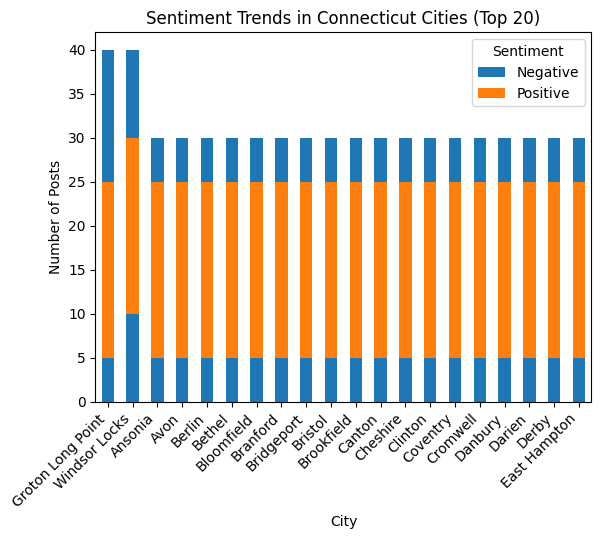

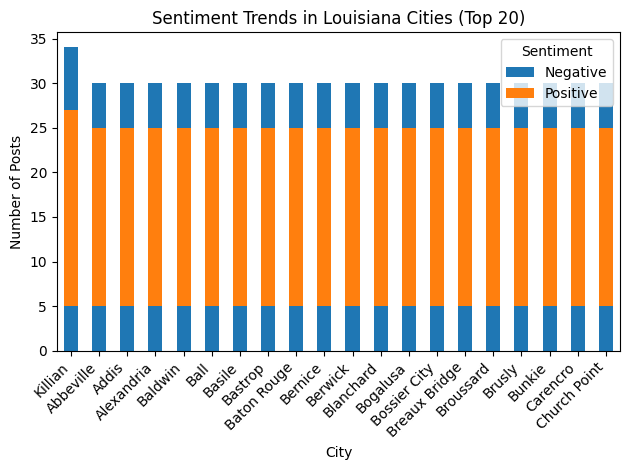

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'social_media_real_estate' DataFrame is already processed as in the provided code.

def analyze_sentiment(df, state):
    state_df = df[df['state'] == state]

    # Get sentiment counts for both content and comment sentiment labels
    content_sentiments = state_df.groupby('city')['content_sentiment_label'].value_counts().unstack(fill_value=0)
    comment_sentiments = state_df.groupby('city')['comments_sentiment_label'].value_counts().unstack(fill_value=0)

    # Combine content and comment sentiment counts
    combined_sentiments = content_sentiments.add(comment_sentiments, fill_value=0)

    # Sort by the total sentiment count across content and comment
    top_cities = combined_sentiments.sum(axis=1).nlargest(20).index
    top_city_sentiments = combined_sentiments.loc[top_cities]

    return top_city_sentiments

# Analyze sentiment for Connecticut
ct_sentiments = analyze_sentiment(social_media_real_estate, 'Connecticut')

# Analyze sentiment for Louisiana
la_sentiments = analyze_sentiment(social_media_real_estate, 'Louisiana')

# Plotting the results for both states
# plt.figure(figsize=(14, 7))

# Plot for Connecticut
ct_sentiments.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'])  # Custom colors for Positive/Negative
plt.title('Sentiment Trends in Connecticut Cities (Top 20)')
plt.xlabel('City')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])

# Plot for Louisiana
la_sentiments.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'])  # Custom colors for Positive/Negative
plt.title('Sentiment Trends in Louisiana Cities (Top 20)')
plt.xlabel('City')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])

plt.tight_layout()
plt.show()


##### What are the major concerns buyers and renters have in these states? (Safety, affordability, job market, etc.)

In [5]:
def analyze_concerns(df, state):
    """Analyzes major concerns from text data for a given state."""

    state_df = df[df['state'] == state]
    concerns = {}

    for _, row in state_df.iterrows():
        text = str(row['content']) + " " + str(row['comments'])  # Combine content and comments
        text = text.lower()

        # Check for keywords related to different concerns
        if "safety" in text or "crime" in text or "dangerous" in text:
            concerns["Safety"] = concerns.get("Safety", 0) + 1
        if "affordability" in text or "expensive" in text or "rent" in text or "mortgage" in text or "cost" in text:
            concerns["Affordability"] = concerns.get("Affordability", 0) + 1
        if "job" in text or "employment" in text or "unemployment" in text or "career" in text or "market" in text:
            concerns["Job Market"] = concerns.get("Job Market", 0) + 1
        if "school" in text or "education" in text:
            concerns["Schools"] = concerns.get("Schools", 0) + 1
        if "infrastructure" in text or "transportation" in text or "roads" in text or "public transit" in text:
            concerns["Infrastructure"] = concerns.get("Infrastructure",0) + 1
        if "taxes" in text or "property tax" in text or "tax rate" in text:
            concerns["Taxes"] = concerns.get("Taxes", 0) + 1
        # Add more concerns and keywords as needed

    return concerns

In [6]:
# Analyze concerns for Connecticut
ct_concerns = analyze_concerns(social_media_real_estate, 'Connecticut')
print("Connecticut Concerns:")
print(ct_concerns)

Connecticut Concerns:
{'Job Market': 1369, 'Affordability': 916}


In [7]:
# Analyze concerns for Louisiana
la_concerns = analyze_concerns(social_media_real_estate, 'Louisiana')
print("\nLouisiana Concerns:")
la_concerns



Louisiana Concerns:


{'Job Market': 1633, 'Affordability': 1091}

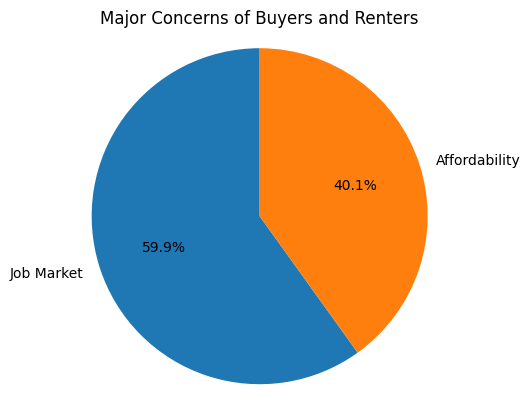

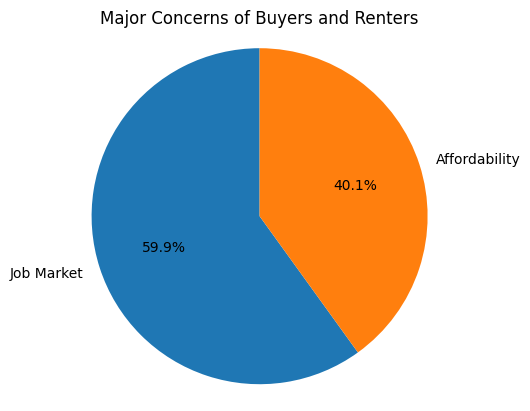

In [8]:
def plot_concerns(concerns):
  """Plots concerns in a pie chart."""
  labels = list(concerns.keys())
  sizes = list(concerns.values())

  fig, ax = plt.subplots()
  ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
  ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.title("Major Concerns of Buyers and Renters")
  plt.show()

plot_concerns(ct_concerns)
plot_concerns(la_concerns)

##### How does sentiment on social media correlate with actual property prices?

Correlation between property price and major sentiment: 0.03


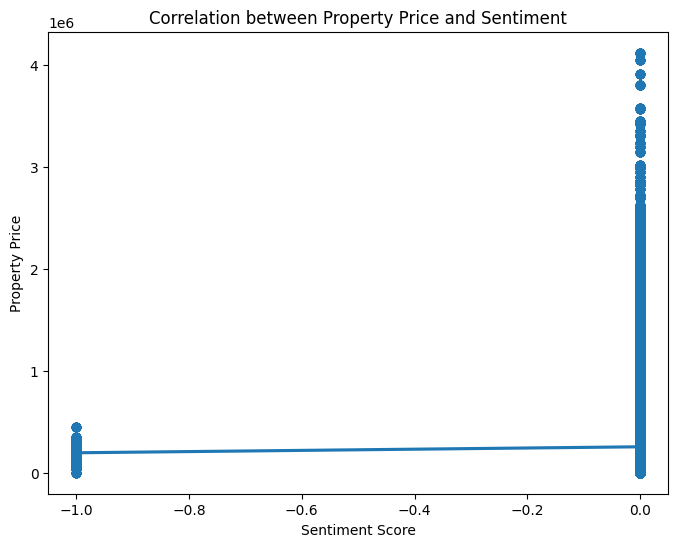

In [9]:
# Merge the dataframes on 'City'
real_social = pd.merge(real_df, social_media_real_estate, left_on='city', right_on='city', how='inner')

# Group by city and get the major sentiment (the most frequent sentiment per city)
city_sentiment = real_social.groupby('city')['content_sentiment_label'].agg(lambda x: x.value_counts().idxmax())

# Merge the major sentiment back into the merged dataframe
real_social = pd.merge(real_social, city_sentiment.rename('major_sentiment'), left_on='city', right_index=True)

# Map sentiment labels to numerical values: Negative (-1), Neutral (0), Positive (1)
sentiment_mapping = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
real_social['sentiment_score'] = real_social['major_sentiment'].map(sentiment_mapping)

# Calculate the correlation between property price and sentiment score
correlation = real_social['median_sale_price'].corr(real_social['sentiment_score'])
print(f"Correlation between property price and major sentiment: {correlation:.2f}")

# Plotting the correlation using a seaborn regplot
plt.figure(figsize=(8, 6))
sns.regplot(x='sentiment_score', y='median_sale_price', data=real_social)
plt.title('Correlation between Property Price and Sentiment')
plt.xlabel('Sentiment Score')
plt.ylabel('Property Price')
plt.show()

In [10]:
# Group data by city and sentiment to explore variations
city_sentiment_price = real_social.groupby(['city', 'major_sentiment'])['median_sale_price'].mean().reset_index()

# Create an interactive plot using Plotly Express to show average price by sentiment for each city
fig = px.scatter(city_sentiment_price, x='major_sentiment', y='median_sale_price', color='city',
                 title='Average Property Price by City and Major Sentiment',
                 labels={'major_sentiment': 'Sentiment', 'Price': 'Average Property Price'},
                 hover_data=['city', 'median_sale_price'])
fig.show()

##### . What are the key phrases associated with positive and negative sentiments in real estate discussions?


In [14]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import nltk
from nltk.util import ngrams

# Assuming you already have a DataFrame with the necessary sentiment labels
# Sample DataFrame: social_media_real_estate (content_sentiment and comment_sentiment)
df = social_media_real_estate
df = social_media_real_estate[social_media_real_estate['state'] == "Connecticut"].copy()

# Combine content and comment sentiment to create the final sentiment
df['final_sentiment'] = df.apply(lambda row: 'Positive' if row['content_sentiment_label'] == 'Positive' or row['comments_sentiment_label'] == 'Positive' else 'Negative', axis=1)

# Function to extract n-grams
def extract_ngrams(text, n=2):
    # Tokenize the text and extract n-grams
    tokens = nltk.word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return [' '.join(gram) for gram in n_grams]

# Extract key phrases (bigrams or trigrams) from content and comments
df['content_ngrams'] = df['content'].apply(lambda x: extract_ngrams(x, n=2))  # Extract bigrams
df['comment_ngrams'] = df['comments'].apply(lambda x: extract_ngrams(x, n=2))  # Extract bigrams

# Filter key phrases by sentiment
positive_phrases = pd.concat([
    df[df['final_sentiment'] == 'Positive']['content_ngrams'].explode(),
    df[df['final_sentiment'] == 'Positive']['comment_ngrams'].explode()
])
negative_phrases = pd.concat([
    df[df['final_sentiment'] == 'Negative']['content_ngrams'].explode(),
    df[df['final_sentiment'] == 'Negative']['comment_ngrams'].explode()
])
#negative_phrases = df[df['final_sentiment'] == 'Negative']['content_ngrams'].explode().append(df[df['final_sentiment'] == 'Negative']['comment_ngrams'].explode())

# Get the top 20 most frequent phrases for positive and negative sentiments
positive_top_phrases = Counter(positive_phrases).most_common(20)
negative_top_phrases = Counter(negative_phrases).most_common(20)

print("Top 20 Positive Phrases:")
print(positive_top_phrases)

print("\nTop 20 Negative Phrases:")
print(negative_top_phrases)

# Prepare data for Plotly
pos_df = pd.DataFrame(positive_top_phrases, columns=['Phrase', 'Count'])
neg_df = pd.DataFrame(negative_top_phrases, columns=['Phrase', 'Count'])
fig_pos = px.bar(
    pos_df,
    x='Phrase',
    y='Count',
    title=f'Top 10 Positive Key Phrases in Conecticut',
    labels={'Count': 'Frequency'},
    color='Count',
    color_continuous_scale='Blues',
    template='plotly_dark'
)
fig_pos.show()


# Plot Top Negative Phrases with Plotly
fig_neg = px.bar(
    neg_df,
    x='Phrase',
    y='Count',
    title=f'Top 10 Negative Key Phrases in Connecticut',
    labels={'Count': 'Frequency'},
    color='Count',
    color_continuous_scale='Reds',
    template='plotly_dark'
)
fig_neg.show()

Top 20 Positive Phrases:
[('list agent', 1377), ('make offer', 1377), ('. maybe', 938), ('agent reach', 928), ('full market', 928), ('market .', 928), ('id consider', 928), ('fair offer', 928), ('. dont', 928), ('offer .', 928), ('reach list', 913), ('offer stand', 913), ('real estate', 908), (', real', 898), ('estate agent', 898), (') .', 479), ('deal .', 474), ('. also', 469), (', price', 469), (', would', 469)]

Top 20 Negative Phrases:
[('phone number', 896), ('investment company', 896), ('property .', 896), ('william erickson', 896), ('erickson ,', 896), ('. call', 896), ('neighborhood .', 894), ('lot work', 894), ('work (', 894), ('price .', 894), ('? isnt', 894), ('isnt go', 894), ('go qualify', 894), ('qualify traditional', 894), ('traditional finance', 894), ('finance .', 894), ('investor go', 894), ('bank .', 894), ('real estate', 458), ('offer .', 457)]


In [15]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import nltk
from nltk.util import ngrams

# Assuming you already have a DataFrame with the necessary sentiment labels
# Sample DataFrame: social_media_real_estate (content_sentiment and comment_sentiment)
df = social_media_real_estate
df = social_media_real_estate[social_media_real_estate['state'] == "Louisiana"].copy()

# Combine content and comment sentiment to create the final sentiment
df['final_sentiment'] = df.apply(lambda row: 'Positive' if row['content_sentiment_label'] == 'Positive' or row['comments_sentiment_label'] == 'Positive' else 'Negative', axis=1)

# Function to extract n-grams
def extract_ngrams(text, n=2):
    # Tokenize the text and extract n-grams
    tokens = nltk.word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return [' '.join(gram) for gram in n_grams]

# Extract key phrases (bigrams or trigrams) from content and comments
df['content_ngrams'] = df['content'].apply(lambda x: extract_ngrams(x, n=2))  # Extract bigrams
df['comment_ngrams'] = df['comments'].apply(lambda x: extract_ngrams(x, n=2))  # Extract bigrams

# Filter key phrases by sentiment
positive_phrases = pd.concat([
    df[df['final_sentiment'] == 'Positive']['content_ngrams'].explode(),
    df[df['final_sentiment'] == 'Positive']['comment_ngrams'].explode()
])
negative_phrases = pd.concat([
    df[df['final_sentiment'] == 'Negative']['content_ngrams'].explode(),
    df[df['final_sentiment'] == 'Negative']['comment_ngrams'].explode()
])
#negative_phrases = df[df['final_sentiment'] == 'Negative']['content_ngrams'].explode().append(df[df['final_sentiment'] == 'Negative']['comment_ngrams'].explode())

# Get the top 20 most frequent phrases for positive and negative sentiments
positive_top_phrases = Counter(positive_phrases).most_common(20)
negative_top_phrases = Counter(negative_phrases).most_common(20)

print("Top 20 Positive Phrases:")
print(positive_top_phrases)

print("\nTop 20 Negative Phrases:")
print(negative_top_phrases)

# Prepare data for Plotly
pos_df = pd.DataFrame(positive_top_phrases, columns=['Phrase', 'Count'])
neg_df = pd.DataFrame(negative_top_phrases, columns=['Phrase', 'Count'])
fig_pos = px.bar(
    pos_df,
    x='Phrase',
    y='Count',
    title=f'Top 10 Positive Key Phrases in Louisiana',
    labels={'Count': 'Frequency'},
    color='Count',
    color_continuous_scale='Blues',
    template='plotly_dark'
)
fig_pos.show()


# Plot Top Negative Phrases with Plotly
fig_neg = px.bar(
    neg_df,
    x='Phrase',
    y='Count',
    title=f'Top 10 Negative Key Phrases in Louisiana',
    labels={'Count': 'Frequency'},
    color='Count',
    color_continuous_scale='Reds',
    template='plotly_dark'
)
fig_neg.show()

Top 20 Positive Phrases:
[('list agent', 1641), ('make offer', 1641), (', real', 1094), ('real estate', 1094), ('estate agent', 1094), ('reach list', 1094), ('offer stand', 1094), ('agent reach', 1094), ('full market', 1094), ('market .', 1094), ('. maybe', 1094), ('id consider', 1094), ('fair offer', 1094), ('. dont', 1094), ('offer .', 1094), ("'re interest", 547), ('interest buy', 547), ('buy neighbor', 547), ("neighbor 's", 547), ("'s house", 547)]

Top 20 Negative Phrases:
[('neighborhood .', 1088), ('lot work', 1088), ('work (', 1088), ('price .', 1088), ('? isnt', 1088), ('isnt go', 1088), ('go qualify', 1088), ('qualify traditional', 1088), ('traditional finance', 1088), ('finance .', 1088), ('investor go', 1088), ('bank .', 1088), ('phone number', 1084), ('investment company', 1084), ('property .', 1084), ('william erickson', 1084), ('erickson ,', 1084), ('. call', 1084), ('find foreclosure', 544), ('foreclosure house', 544)]
